In [408]:
import torch    
import json 
from ptlpinns.models import model, transfer
from ptlpinns.perturbation import LPM, standard
from ptlpinns.odes import forcing, numerical, equations
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

### Load model

In [409]:
name = "overdamped_k15"

overdamped_path = f"/home/dda24/PTL-PINNs/ptlpinns/models/train/{name}"
overdamped_name = f"model_{name}.pth"
overdamped_model, training_log = model.load_model(overdamped_path, overdamped_name)

15 True True False [128, 128, 256]


### Problem definition

In [410]:
N = 500
t_span = (0, 10)
t_eval = np.linspace(t_span[0], t_span[1], N)

### Compute latent representations

In [411]:
H_dict = transfer.compute_H_dict(overdamped_model, N=N, bias=True, t_span=t_span)

### Transfer parameters

In [412]:
w_list_transfer = [1, 1, 1, 1, 1]
zeta_list = [10, 30, 30, 30]

def forcing(numpy=False):
    if not numpy:
        def force(t):
            return torch.stack((torch.zeros_like(t), torch.zeros_like(t)), dim=1)
    else:
        def force(t):
            return np.stack((np.zeros_like(t), np.zeros_like(t)), axis=1)
    return force

forcing_list = [forcing(True), forcing(True), forcing(True), forcing(True), forcing(True)]

forcing_1D = lambda t: np.zeros_like(t)
ic_list = [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
epsilon_list = [0.5, 0.5, 0.5, 0.5, 0.5]
p_list = [6]
q = [(3, 1)]

### Numerical solver

In [413]:
numerical_list = []

for zeta in zeta_list:
    ode = equations.ode_oscillator_1D(w_0=w_list_transfer[0], zeta=zeta, forcing_1D=forcing_1D, q=q, epsilon=epsilon_list[0])
    numerical_list.append(numerical.solve_ode_equation(ode, (t_eval[0], t_eval[-1]), t_eval, ic_list[0]))

### PINN

In [414]:
NN_TL_solution, perturbation_solution, _ = transfer.compute_perturbation_solution(w_list_transfer, zeta_list, epsilon_list, p_list, ic_list, forcing_list, H_dict, t_eval, training_log, all_p=True, comp_time=False, solver="standard", power=q)
NN_TL_solution = NN_TL_solution.squeeze()

In [415]:
NN_TL_solution.shape

(500, 4, 2)

In [416]:
PINN_solution = []

for perturbation_zeta in perturbation_solution:

    perturbation = []
    for perturbation_order in perturbation_zeta:

        perturbation.append(perturbation_order[:, 0])

    PINN_solution.append(standard.calculate_general_series(perturbation, epsilon_list[0]))

zeta: 10, order: 0, mean error absolute: 0.05818502289938489
zeta: 10, order: 1, mean error absolute: 0.009172995286509049
zeta: 10, order: 2, mean error absolute: 0.001824608486473311
zeta: 10, order: 3, mean error absolute: 0.0003818473350207812
zeta: 10, order: 4, mean error absolute: 0.0001139057864199149
zeta: 10, order: 5, mean error absolute: 3.15272252601897e-05


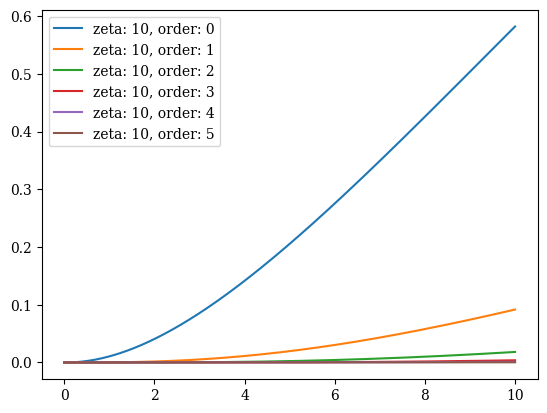

zeta: 30, order: 0, mean error absolute: 0.031180991653153935
zeta: 30, order: 1, mean error absolute: 0.00235133375563777
zeta: 30, order: 2, mean error absolute: 0.00019015403005443886
zeta: 30, order: 3, mean error absolute: 0.00016640194827848443
zeta: 30, order: 4, mean error absolute: 0.00015026457543478066
zeta: 30, order: 5, mean error absolute: 0.00015177595107702846


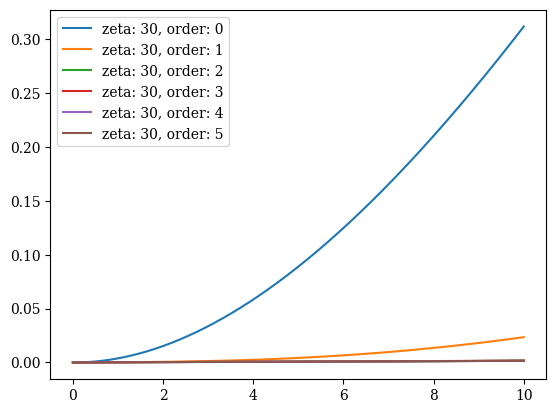

zeta: 30, order: 0, mean error absolute: 0.031180991653153935
zeta: 30, order: 1, mean error absolute: 0.00235133375563777
zeta: 30, order: 2, mean error absolute: 0.00019015403005443886
zeta: 30, order: 3, mean error absolute: 0.00016640194827848443
zeta: 30, order: 4, mean error absolute: 0.00015026457543478066
zeta: 30, order: 5, mean error absolute: 0.00015177595107702846


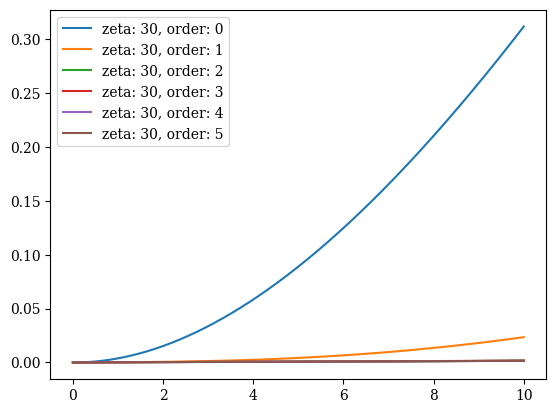

zeta: 30, order: 0, mean error absolute: 0.031180991653153935
zeta: 30, order: 1, mean error absolute: 0.00235133375563777
zeta: 30, order: 2, mean error absolute: 0.00019015403005443886
zeta: 30, order: 3, mean error absolute: 0.00016640194827848443
zeta: 30, order: 4, mean error absolute: 0.00015026457543478066
zeta: 30, order: 5, mean error absolute: 0.00015177595107702846


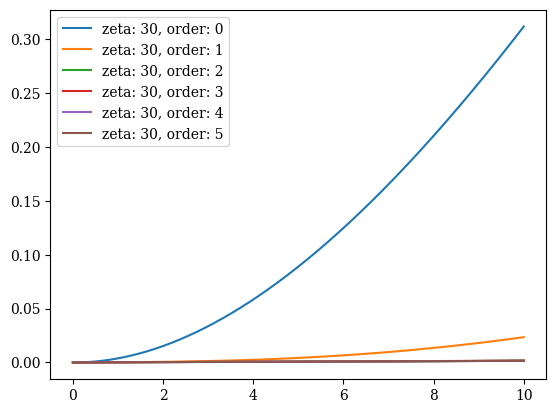

In [417]:
standard.plot_error_by_order(t_eval, PINN_solution, numerical_list, p_list, zeta_list, "zeta")

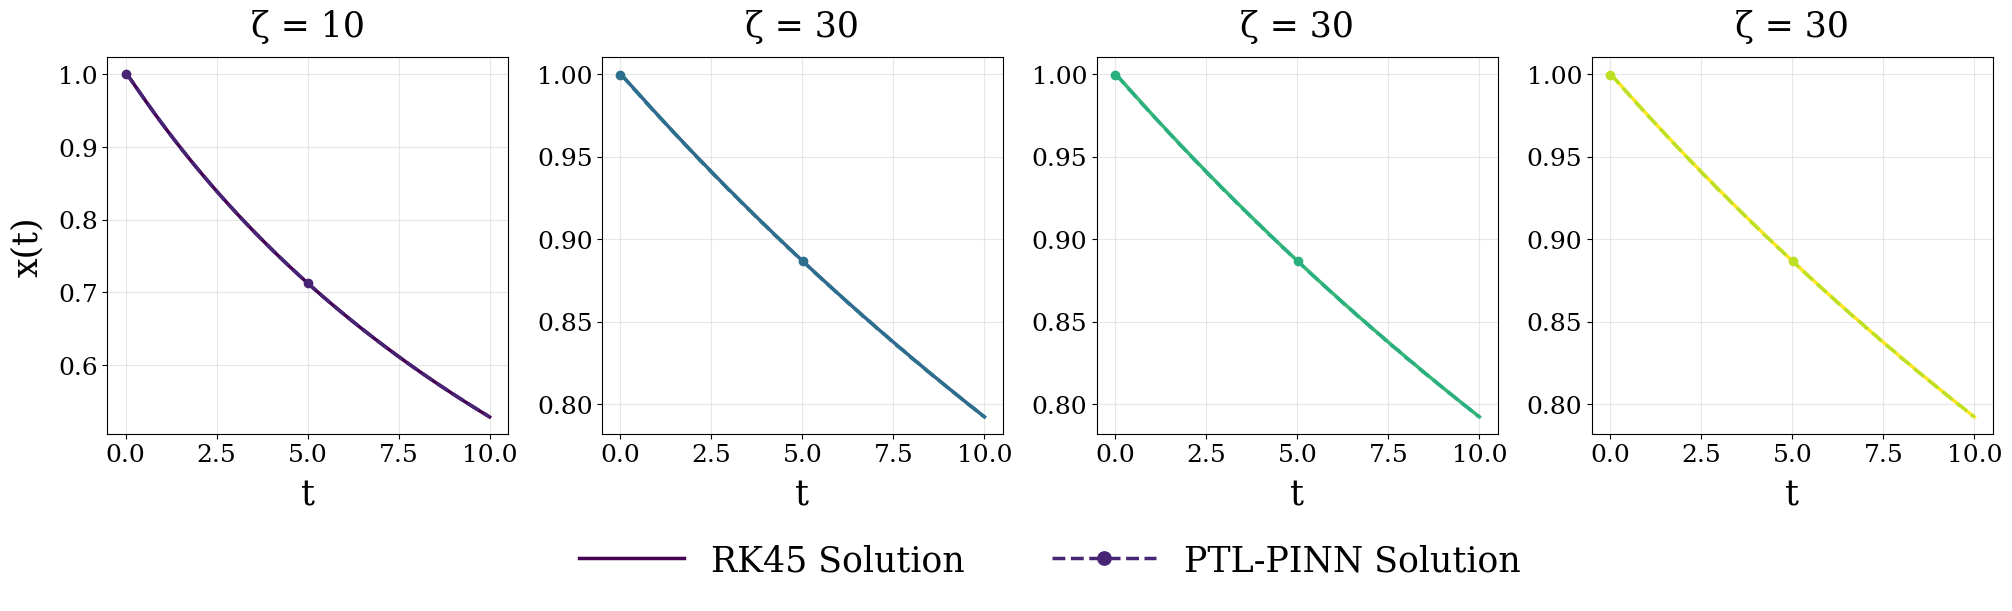

In [418]:
standard.plot_compare_multiple_zeta(t_eval, zeta_list, numerical_list, NN_TL_solution)


zeta: 10, mean Error: 2.727e-05
zeta: 30, mean Error: 1.516e-04
zeta: 30, mean Error: 1.516e-04
zeta: 30, mean Error: 1.516e-04


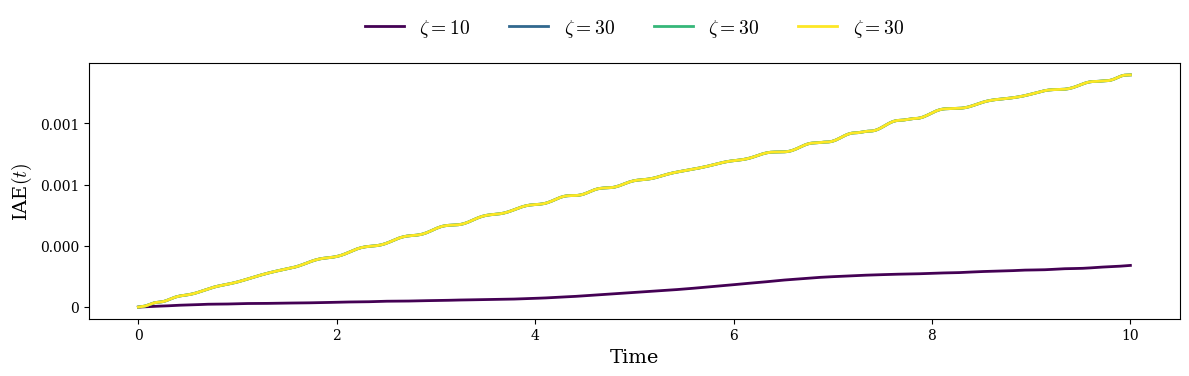

In [419]:
standard.plot_IAE_multiple_zeta(zeta_list, t_eval, NN_TL_solution, numerical_list)

/tmp/ipykernel_133757/2572481309.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", 3)


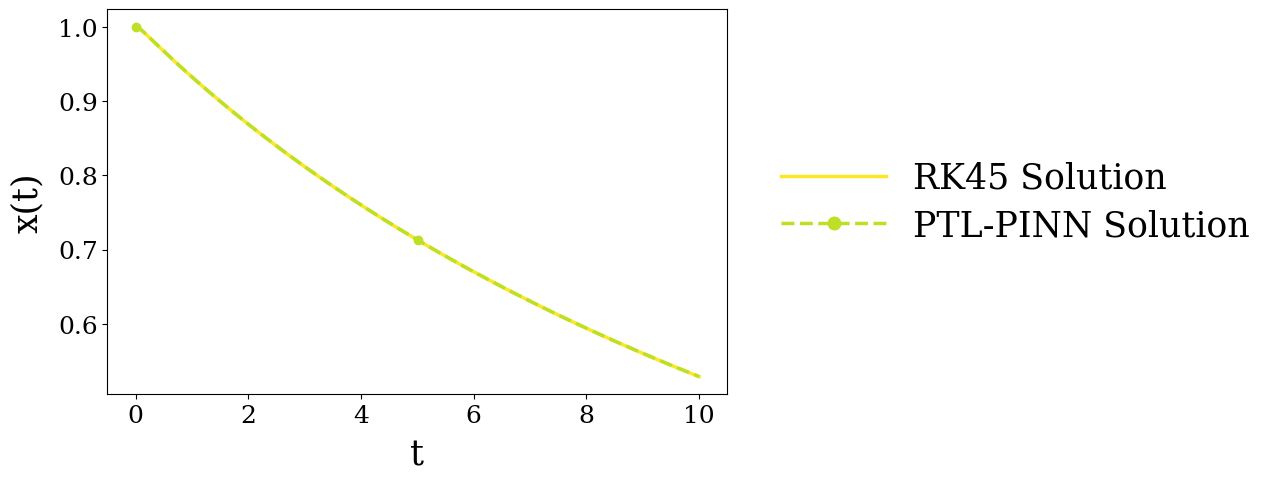

In [420]:
import matplotlib.cm as cm

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"],
    "mathtext.fontset": "cm",
    "text.usetex": False,
})

def plot_solution(t_eval, y_num, y_nn, i = 3):
    title_fs  = 25
    label_fs  = 25
    tick_fs   = 18
    legend_fs = 25
    cmap = cm.get_cmap("viridis", 3)

    fig, ax = plt.subplots(figsize=(8, 5))

    base_color = cmap(i / 2)
    rk_color   = base_color
    pinn_color = cm.viridis(0.1 + 0.8 * i / 2)

    ax.plot(t_eval, y_num,
            label="RK45 Solution",
            color=rk_color, linewidth=2.5)

    ax.plot(t_eval, y_nn,
            label="PTL-PINN Solution",
            color=pinn_color, linewidth=2.5,
            linestyle="--", marker="o", markevery=250)

    ax.set_xlabel("t", fontsize=label_fs, labelpad=8)
    ax.set_ylabel("x(t)", fontsize=label_fs, labelpad=10)

    ax.tick_params(axis='both', labelsize=tick_fs)

    # Set y-limits with padding
    y_min = min(np.min(y_num), np.min(y_nn))
    y_max = max(np.max(y_num), np.max(y_nn))
    pad = 0.05 * max(1e-12, (y_max - y_min))
    ax.set_ylim(y_min - pad, y_max + pad)

    ax.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),  # (x, y): anchor the legend outside the right border
    fontsize=legend_fs,
    frameon=False,
    handlelength=3.0,
    markerscale=1.5,
    labelspacing=0.4,
    borderaxespad=0.8)
    plt.show()

plot_solution(t_eval, numerical_list[0][0, :], NN_TL_solution[:, 0, 0], i = 2)

### Compare high acc

In [421]:
scale = int(10000 / N)
scale

20

In [422]:
ode_high_acc = equations.ode_oscillator_1D(w_0=1, zeta=zeta_list[1], forcing_1D=forcing_1D, q=q, epsilon=epsilon_list[0])
dt = (t_eval[1] - t_eval[0])/scale
t_eval_high_acc = np.linspace(t_span[0], t_span[1], (t_eval.size - 1)*scale + 1)
num_high_acc = numerical.solve_ode_equation(ode_high_acc, (t_eval_high_acc[0], t_eval_high_acc[-1]), t_eval_high_acc, ic_list[0])[0, :]

In [423]:
t_eval

array([ 0.        ,  0.02004008,  0.04008016,  0.06012024,  0.08016032,
        0.1002004 ,  0.12024048,  0.14028056,  0.16032064,  0.18036072,
        0.2004008 ,  0.22044088,  0.24048096,  0.26052104,  0.28056112,
        0.3006012 ,  0.32064128,  0.34068136,  0.36072144,  0.38076152,
        0.4008016 ,  0.42084168,  0.44088176,  0.46092184,  0.48096192,
        0.501002  ,  0.52104208,  0.54108216,  0.56112224,  0.58116232,
        0.6012024 ,  0.62124248,  0.64128257,  0.66132265,  0.68136273,
        0.70140281,  0.72144289,  0.74148297,  0.76152305,  0.78156313,
        0.80160321,  0.82164329,  0.84168337,  0.86172345,  0.88176353,
        0.90180361,  0.92184369,  0.94188377,  0.96192385,  0.98196393,
        1.00200401,  1.02204409,  1.04208417,  1.06212425,  1.08216433,
        1.10220441,  1.12224449,  1.14228457,  1.16232465,  1.18236473,
        1.20240481,  1.22244489,  1.24248497,  1.26252505,  1.28256513,
        1.30260521,  1.32264529,  1.34268537,  1.36272545,  1.38

In [424]:
t_eval_high_acc[1] - t_eval_high_acc[0]

np.float64(0.001002004008016032)

In [425]:
num_low_acc = numerical.solve_ode_equation(ode_high_acc, (t_eval[0], t_eval[-1]), t_eval, ic_list[0], rtol=1e-5, atol=1e-5, method="Radau")[0, :]
np.mean(np.abs(num_low_acc - num_high_acc[::scale]))

np.float64(7.372598440087418e-07)

In [426]:
error = []
for i in range(p_list[0]):
    error.append(np.mean(np.abs(PINN_solution[1][i] - num_high_acc[::scale])))

In [427]:
error

[np.float64(0.031180991653153935),
 np.float64(0.002351333755637772),
 np.float64(0.00019015403005443775),
 np.float64(0.00016640194827848598),
 np.float64(0.00015026457543478223),
 np.float64(0.00015177595107703)]

###
```

```

### zeta = 10

```
N = 50:

[np.float64(0.02140165652919763),
 np.float64(0.01857787988770352),
 np.float64(0.01575689587541253),
 np.float64(0.016025502612038073),
 np.float64(0.015996830983275968),
 np.float64(0.016000109162551707)]

 N = 100:

 [np.float64(0.031084773214696115),
 np.float64(0.002370341184428487),
 np.float64(0.00018362933464561416),
 np.float64(0.00018714127192448138),
 np.float64(0.00016582077389849182),
 np.float64(0.00016808621526585355)]

N = 200:

[np.float64(0.031299760865125946),
 np.float64(0.002185114003985875),
 np.float64(0.0002350018949113719),
 np.float64(8.733474593653201e-05),
 np.float64(8.768742607794367e-05),
 np.float64(8.72843739680157e-05)]

N = 400:

[np.float64(0.03118214365845811),
 np.float64(0.0023942600523281982),
 np.float64(0.00018765378835034236),
 np.float64(0.0002034996590992963),
 np.float64(0.00018449822321691927),
 np.float64(0.00018636145160865064)]

N = 500:

[np.float64(0.031180991653153935),
 np.float64(0.002351333755637772),
 np.float64(0.00019015403005443775),
 np.float64(0.00016640194827848598),
 np.float64(0.00015026457543478223),
 np.float64(0.00015177595107703)]
```